# Capstone - Dividend Predictor Machine Learning 
## Goal of project is to use machine learning (Linear, Lasso, Ridge, ElasticNet, RandomForestRegressor, and GradientBoostingRegressor) to determine a company's predicted dividend per share based on fundmental factors such as profitability, margins, and free cash flow.

## Secondarily, use KMeans clustering algorithim to help determine insights into whether important regime (time periods) need to be further explored (Recessions, bubbles, etc.) 

### The rationale for this project is to determine if a company's current dividend makes sense based on the current fundamentals of the firm. Historically dividends have accounted for nearly half of the overall returns for the stock market over long periods and are very important to some investors. As importantly, dividends are often seen as way for management to "signal" to investors that their firm is growing and/or at least on firm financial footing. CEOs are  reluctant to cut their dividend because it could imply poor future prospects. Therefore, investors could be vulnerable to stock corrections if they rely too much management's signals, particularly when the implied sustainable dividend payout should be much lower. Therefore a quantitative approach, using machine learning is one method to use as an objective measure to help trinangulate a clue to a firm's dividend health. 

### Brett Slattery, CFA
###### Data: GuruFocus. Algorithms: EliteDataScience Academy

## Library Imports

In [1]:
#basic import libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

#machine learning libraries


from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import pickle

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)



## Pre Analysis Prep and Early Data Cleaning

In [2]:
#Retrieving the CSV
df = pd.read_csv('IFF_Financial_Data.csv')

#Preliminary cleanup of column names

df.columns = [x.strip().replace('per_share_data_array-', '') for x in df.columns]
df.columns = [x.strip().replace('common_size_ratios-', '') for x in df.columns]
df.columns = [x.strip().replace('valuation_and_quality-', '') for x in df.columns]
df.columns = [x.strip().replace('valuation_ratios-', '') for x in df.columns]
df.columns = [x.strip().replace('cashflow_statement-', '') for x in df.columns]
df.columns = [x.strip().replace('balance_sheet-', '') for x in df.columns]
df.columns = [x.strip().replace('income_statement-', '') for x in df.columns]

#remove unnecessary column
del df['Preliminary']


#needed to replace TTM because it wasn't recognized as date below
df = df.replace('TTM', '2020-02')
df = df.drop('Unnamed: 0', axis=1)


df = df.set_index('Fiscal Year')
#changes the object to numeric - couldn't do calculations
df = df.apply(pd.to_numeric, errors='coerce')

df.index = pd.to_datetime(df.index)

pd.set_option('display.max_columns', None)

#drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]
df = df.iloc[30:,:] # to limit to 2008 onward 

round(df,1).head(5)


,Revenue per Share,EBITDA per Share,EBIT per Share,Earnings per Share (Diluted),EPS without NRI,Owner Earnings per Share (TTM),Free Cash Flow per Share,Operating Cash Flow per Share,Dividends per Share,Book Value per Share,Tangible Book per Share,Total Debt per Share,Month End Stock Price,ROE %,ROE % Adjusted to Book Value,ROA %,Return-on-Tangible-Equity,Return-on-Tangible-Asset,ROC (Joel Greenblatt) %,ROIC %,WACC %,Effective Interest Rate on Debt %,Gross Margin %,Operating Margin %,Net Margin %,FCF Margin %,Debt-to-Equity,Equity-to-Asset,Debt-to-Asset,Gross-Profit-to-Asset %,Asset Turnover,Dividend Payout Ratio,Days Sales Outstanding,Days Payable,Days Inventory,Cash Conversion Cycle,Inventory Turnover,COGS-to-Revenue,Inventory-to-Revenue,Revenue,Cost of Goods Sold,Gross Profit,"Selling, General, & Admin. Expense",Research & Development,Other Operating Expense,Operating Income,Interest Income,Interest Expense,Net Interest Income,Other Income (Expense),Other Income (Minority Interest),Pretax Income,Tax Provision,Tax Rate %,Net Income (Continuing Operations),Net Income (Discontinued Operations),Net Income,Preferred Dividends,EPS (Basic),EPS (Diluted),Shares Outstanding (Diluted Average),"Depreciation, Depletion and Amortization",EBITDA,Cash And Cash Equivalents,Marketable Securities,"Cash, Cash Equivalents, Marketable Securities",Accounts Receivable,Notes Receivable,Loans Receivable,Other Current Receivables,Total Receivables,"Inventories, Raw Materials & Components","Inventories, Work In Process","Inventories, Inventories Adjustments","Inventories, Finished Goods","Inventories, Other",Total Inventories,Other Current Assets,Total Current Assets,Investments And Advances,Land And Improvements,Buildings And Improvements,"Machinery, Furniture, Equipment",Construction In Progress,Other Gross PPE,"Gross Property, Plant and Equipment",Accumulated Depreciation,"Property, Plant and Equipment",Intangible Assets,Goodwill,Other Long Term Assets,Total Assets,Accounts Payable,Total Tax Payable,Other Current Payables,Current Accrued Expense,Accounts Payable & Accrued Expense,Short-Term Debt,Short-Term Capital Lease Obligation,Short-Term Debt & Capital Lease Obligation,Current Deferred Revenue,Current Deferred Taxes Liabilities,Deferred Tax And Revenue,Other Current Liabilities,Total Current Liabilities,Long-Term Debt,Long-Term Capital Lease Obligation,Long-Term Debt & Capital Lease Obligation,Pension And Retirement Benefit,NonCurrent Deferred Liabilities,Other Long-Term Liabilities,Total Liabilities,Common Stock,Preferred Stock,Retained Earnings,Accumulated other comprehensive income (loss),Additional Paid-In Capital,Treasury Stock,Other Stockholders Equity,Total Stockholders Equity,Minority Interest,Total Equity,Net Income From Continuing Operations,"Cash Flow Depreciation, Depletion and Amortization",Change In Receivables,Change In Inventory,Change In Prepaid Assets,Change In Payables And Accrued Expense,Change In Working Capital,Change In DeferredTax,Stock Based Compensation,Asset Impairment Charge,Cash from Discontinued Operating Activities,Cash Flow from Others,Cash Flow from Operations,"Purchase Of Property, Plant, Equipment","Sale Of Property, Plant, Equipment",Purchase Of Business,Sale Of Business,Purchase Of Investment,Sale Of Investment,Net Intangibles Purchase And Sale,Cash From Discontinued Investing Activities,Cash From Other Investing Activities,Cash Flow from Investing,Issuance of Stock,Repurchase of Stock,Net Issuance of Preferred Stock,Net Issuance of Debt,Cash Flow for Dividends,Other Financing,Cash Flow from Financing,Effect of Exchange Rate Changes,Net Change in Cash,Capital Expenditure,Free Cash Flow,PE Ratio,Price-to-Owner-Earnings,PB Ratio,Price-to-Tangible-Book,Price-to-Free-Cash-Flow,Price-to-Operating-Cash-Flow,PS Ratio,PEG Ratio,EV-to-Revenue,EV-to-EBITDA,EV-to-EBIT,Earnings Yield (Joel Greenblatt) %,Forward Rate of Return (Yacktman) %,Shiller PE Ratio,Dividend Yield %,Market Cap,Enterprise Value ($M),Net Cash per Sh

In [3]:
#Review recent data to ensure it looks reasonable. Month Stock price should be $129.02
df.tail(2)

,Revenue per Share,EBITDA per Share,EBIT per Share,Earnings per Share (Diluted),EPS without NRI,Owner Earnings per Share (TTM),Free Cash Flow per Share,Operating Cash Flow per Share,Dividends per Share,Book Value per Share,Tangible Book per Share,Total Debt per Share,Month End Stock Price,ROE %,ROE % Adjusted to Book Value,ROA %,Return-on-Tangible-Equity,Return-on-Tangible-Asset,ROC (Joel Greenblatt) %,ROIC %,WACC %,Effective Interest Rate on Debt %,Gross Margin %,Operating Margin %,Net Margin %,FCF Margin %,Debt-to-Equity,Equity-to-Asset,Debt-to-Asset,Gross-Profit-to-Asset %,Asset Turnover,Dividend Payout Ratio,Days Sales Outstanding,Days Payable,Days Inventory,Cash Conversion Cycle,Inventory Turnover,COGS-to-Revenue,Inventory-to-Revenue,Revenue,Cost of Goods Sold,Gross Profit,"Selling, General, & Admin. Expense",Research & Development,Other Operating Expense,Operating Income,Interest Income,Interest Expense,Net Interest Income,Other Income (Expense),Other Income (Minority Interest),Pretax Income,Tax Provision,Tax Rate %,Net Income (Continuing Operations),Net Income (Discontinued Operations),Net Income,Preferred Dividends,EPS (Basic),EPS (Diluted),Shares Outstanding (Diluted Average),"Depreciation, Depletion and Amortization",EBITDA,Cash And Cash Equivalents,Marketable Securities,"Cash, Cash Equivalents, Marketable Securities",Accounts Receivable,Notes Receivable,Loans Receivable,Other Current Receivables,Total Receivables,"Inventories, Raw Materials & Components","Inventories, Work In Process","Inventories, Inventories Adjustments","Inventories, Finished Goods","Inventories, Other",Total Inventories,Other Current Assets,Total Current Assets,Investments And Advances,Land And Improvements,Buildings And Improvements,"Machinery, Furniture, Equipment",Construction In Progress,Other Gross PPE,"Gross Property, Plant and Equipment",Accumulated Depreciation,"Property, Plant and Equipment",Intangible Assets,Goodwill,Other Long Term Assets,Total Assets,Accounts Payable,Total Tax Payable,Other Current Payables,Current Accrued Expense,Accounts Payable & Accrued Expense,Short-Term Debt,Short-Term Capital Lease Obligation,Short-Term Debt & Capital Lease Obligation,Current Deferred Revenue,Current Deferred Taxes Liabilities,Deferred Tax And Revenue,Other Current Liabilities,Total Current Liabilities,Long-Term Debt,Long-Term Capital Lease Obligation,Long-Term Debt & Capital Lease Obligation,Pension And Retirement Benefit,NonCurrent Deferred Liabilities,Other Long-Term Liabilities,Total Liabilities,Common Stock,Preferred Stock,Retained Earnings,Accumulated other comprehensive income (loss),Additional Paid-In Capital,Treasury Stock,Other Stockholders Equity,Total Stockholders Equity,Minority Interest,Total Equity,Net Income From Continuing Operations,"Cash Flow Depreciation, Depletion and Amortization",Change In Receivables,Change In Inventory,Change In Prepaid Assets,Change In Payables And Accrued Expense,Change In Working Capital,Change In DeferredTax,Stock Based Compensation,Asset Impairment Charge,Cash from Discontinued Operating Activities,Cash Flow from Others,Cash Flow from Operations,"Purchase Of Property, Plant, Equipment","Sale Of Property, Plant, Equipment",Purchase Of Business,Sale Of Business,Purchase Of Investment,Sale Of Investment,Net Intangibles Purchase And Sale,Cash From Discontinued Investing Activities,Cash From Other Investing Activities,Cash Flow from Investing,Issuance of Stock,Repurchase of Stock,Net Issuance of Preferred Stock,Net Issuance of Debt,Cash Flow for Dividends,Other Financing,Cash Flow from Financing,Effect of Exchange Rate Changes,Net Change in Cash,Capital Expenditure,Free Cash Flow,PE Ratio,Price-to-Owner-Earnings,PB Ratio,Price-to-Tangible-Book,Price-to-Free-Cash-Flow,Price-to-Operating-Cash-Flow,PS Ratio,PEG Ratio,EV-to-Revenue,EV-to-EBITDA,EV-to-EBIT,Earnings Yield (Joel Greenblatt) %,Forward Rate of Return (Yacktman) %,Shiller PE Ratio,Dividend Yield %,Market Cap,Enterprise Value ($M),Net Cash per Sh

## Exploratory Analysis

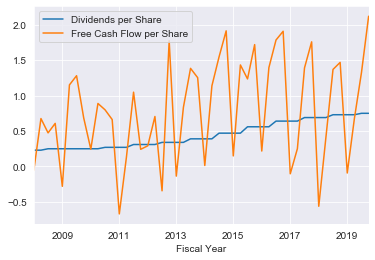

In [4]:
df[['Dividends per Share', 'Free Cash Flow per Share']].plot()
plt.show()
#FCF is lumpy. Will adjust to trailing 12 months later to smooth out

In [5]:
#add TTM
#replace nans with 0 for dividend df['Dividend Payout Ratio'].fillna(0, inplace=True)
df['Dividend Payout Ratio'].fillna(0, inplace=True)
df['Revenue_TTM'] = df['Revenue'].rolling(4, min_periods=1).sum()
df['Gross Profit_TTM'] = df['Gross Profit'].rolling(4, min_periods=1).sum()
df['Operating Income_TTM'] = df['Operating Income'].rolling(4, min_periods=1).sum()
df['Cash Flow from Operations_TTM'] = df['Cash Flow from Operations'].rolling(4, min_periods=1).sum()
df['EBITDA_TTM'] = df['EBITDA'].rolling(4, min_periods=1).sum()
df['Free Cash Flow_TTM'] = df['Free Cash Flow'].rolling(4, min_periods=1).sum()
df['Free Cash Flow per Share_TTM'] = df['Free Cash Flow per Share'].rolling(4, min_periods=1).sum()
df['Earnings per Share (Diluted)_TTM'] = df['Earnings per Share (Diluted)'].rolling(4, min_periods=1).sum()
df['Dividends per Share_TTM'] = df['Dividends per Share'].rolling(4, min_periods=1).sum()
df['Dividend Payout Ratio_TTM'] = df['Dividend Payout Ratio'].rolling(4, min_periods=1).mean()
df['Dividend FCF Payout Ratio_TTM'] = df['Dividends per Share_TTM']/df['Free Cash Flow per Share_TTM']
df['Net Debt to EBITDA'] = (df['Short-Term Debt & Capital Lease Obligation'] + df['Long-Term Debt & Capital Lease Obligation']-df['Cash, Cash Equivalents, Marketable Securities'])/df['EBITDA_TTM']
df['Dividends per Share_TTM YoY Growth'] = df['Dividends per Share_TTM'].pct_change(periods=4)

#create column for highly indebted companies
df['Net Debt to EBITDA High'] = (df['Net Debt to EBITDA']>3.5).astype(int)

#try to eliminate "bump growth year during first period" below


In [6]:
df['Dividend FCF Payout Ratio_TTM'].fillna(0, inplace=True)
df['Dividends per Share_TTM YoY Growth'].fillna(0, inplace=True)

In [7]:
#Review changes to df to determine if formulas were correct
df.head()

,Revenue per Share,EBITDA per Share,EBIT per Share,Earnings per Share (Diluted),EPS without NRI,Owner Earnings per Share (TTM),Free Cash Flow per Share,Operating Cash Flow per Share,Dividends per Share,Book Value per Share,Tangible Book per Share,Total Debt per Share,Month End Stock Price,ROE %,ROE % Adjusted to Book Value,ROA %,Return-on-Tangible-Equity,Return-on-Tangible-Asset,ROC (Joel Greenblatt) %,ROIC %,WACC %,Effective Interest Rate on Debt %,Gross Margin %,Operating Margin %,Net Margin %,FCF Margin %,Debt-to-Equity,Equity-to-Asset,Debt-to-Asset,Gross-Profit-to-Asset %,Asset Turnover,Dividend Payout Ratio,Days Sales Outstanding,Days Payable,Days Inventory,Cash Conversion Cycle,Inventory Turnover,COGS-to-Revenue,Inventory-to-Revenue,Revenue,Cost of Goods Sold,Gross Profit,"Selling, General, & Admin. Expense",Research & Development,Other Operating Expense,Operating Income,Interest Income,Interest Expense,Net Interest Income,Other Income (Expense),Other Income (Minority Interest),Pretax Income,Tax Provision,Tax Rate %,Net Income (Continuing Operations),Net Income (Discontinued Operations),Net Income,Preferred Dividends,EPS (Basic),EPS (Diluted),Shares Outstanding (Diluted Average),"Depreciation, Depletion and Amortization",EBITDA,Cash And Cash Equivalents,Marketable Securities,"Cash, Cash Equivalents, Marketable Securities",Accounts Receivable,Notes Receivable,Loans Receivable,Other Current Receivables,Total Receivables,"Inventories, Raw Materials & Components","Inventories, Work In Process","Inventories, Inventories Adjustments","Inventories, Finished Goods","Inventories, Other",Total Inventories,Other Current Assets,Total Current Assets,Investments And Advances,Land And Improvements,Buildings And Improvements,"Machinery, Furniture, Equipment",Construction In Progress,Other Gross PPE,"Gross Property, Plant and Equipment",Accumulated Depreciation,"Property, Plant and Equipment",Intangible Assets,Goodwill,Other Long Term Assets,Total Assets,Accounts Payable,Total Tax Payable,Other Current Payables,Current Accrued Expense,Accounts Payable & Accrued Expense,Short-Term Debt,Short-Term Capital Lease Obligation,Short-Term Debt & Capital Lease Obligation,Current Deferred Revenue,Current Deferred Taxes Liabilities,Deferred Tax And Revenue,Other Current Liabilities,Total Current Liabilities,Long-Term Debt,Long-Term Capital Lease Obligation,Long-Term Debt & Capital Lease Obligation,Pension And Retirement Benefit,NonCurrent Deferred Liabilities,Other Long-Term Liabilities,Total Liabilities,Common Stock,Preferred Stock,Retained Earnings,Accumulated other comprehensive income (loss),Additional Paid-In Capital,Treasury Stock,Other Stockholders Equity,Total Stockholders Equity,Minority Interest,Total Equity,Net Income From Continuing Operations,"Cash Flow Depreciation, Depletion and Amortization",Change In Receivables,Change In Inventory,Change In Prepaid Assets,Change In Payables And Accrued Expense,Change In Working Capital,Change In DeferredTax,Stock Based Compensation,Asset Impairment Charge,Cash from Discontinued Operating Activities,Cash Flow from Others,Cash Flow from Operations,"Purchase Of Property, Plant, Equipment","Sale Of Property, Plant, Equipment",Purchase Of Business,Sale Of Business,Purchase Of Investment,Sale Of Investment,Net Intangibles Purchase And Sale,Cash From Discontinued Investing Activities,Cash From Other Investing Activities,Cash Flow from Investing,Issuance of Stock,Repurchase of Stock,Net Issuance of Preferred Stock,Net Issuance of Debt,Cash Flow for Dividends,Other Financing,Cash Flow from Financing,Effect of Exchange Rate Changes,Net Change in Cash,Capital Expenditure,Free Cash Flow,PE Ratio,Price-to-Owner-Earnings,PB Ratio,Price-to-Tangible-Book,Price-to-Free-Cash-Flow,Price-to-Operating-Cash-Flow,PS Ratio,PEG Ratio,EV-to-Revenue,EV-to-EBITDA,EV-to-EBIT,Earnings Yield (Joel Greenblatt) %,Forward Rate of Return (Yacktman) %,Shiller PE Ratio,Dividend Yield %,Market Cap,Enterprise Value ($M),Net Cash per Sh

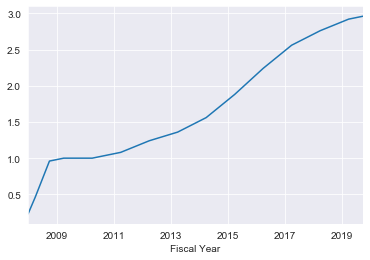

Dividend FCF Payout Ratio_TTM mean: 0.5334252229959048
Dividend FCF Payout Ratio_TTM median: 0.538917861998876


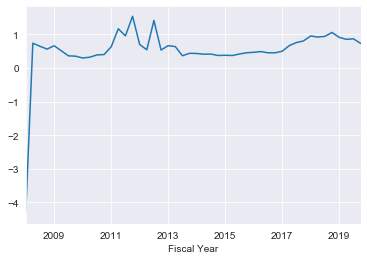

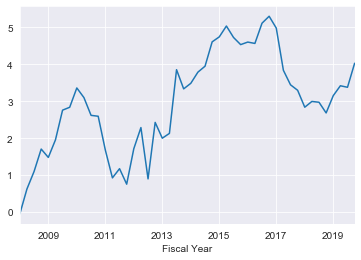

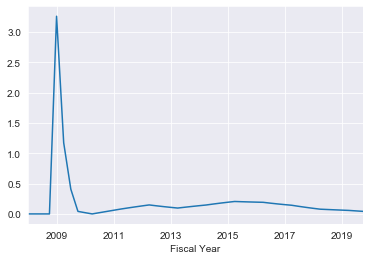

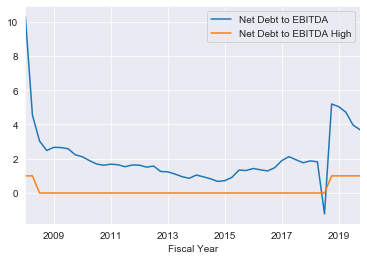

In [8]:
#df['Dividends per Share_TTM YoY Growth'].fillna(0, inplace=True)
df['Dividends per Share_TTM'].plot()
plt.show()

df['Dividend FCF Payout Ratio_TTM'].plot()
print('Dividend FCF Payout Ratio_TTM mean:',df['Dividend FCF Payout Ratio_TTM'].mean())
print('Dividend FCF Payout Ratio_TTM median:',df['Dividend FCF Payout Ratio_TTM'].median())
plt.show()

df['Free Cash Flow per Share_TTM'].plot()
plt.show()

df['Dividends per Share_TTM YoY Growth'].plot()
plt.show()

df[['Net Debt to EBITDA', 'Net Debt to EBITDA High']].plot()
plt.show()

In [9]:
#drop Nan in columns - look at how many were dropped to check reasonableness
print(df.shape)
df = df.dropna(axis='columns')
print(df.shape)


(48, 219)
(48, 216)


## Feature Engineering
### Because companies have different payout ratios, growth prospects, and attitudes toward paying a dividend it is important to be flexible with which factors to use for coeffiicients. Companies in different industries will have nuances with regards to profitability, growth prospects and efficient levels of debt. However, they are all very important to some extent. For example a utilities company can have higher levels of debt due to the underlying stability of their business, while hyper-cylical industrial companies may go bankrupt if their debt level is to high and a sharp drop in profit occurs.There are so many real-world factors that could impact dividend policy, but focusing on a combination of some of the factors listed below covers many of the key drivers.

In [18]:
#Choose features below. Delete "#" to include as coefficients
#I'm purposely choosing to keep the hashtagged features as I experiment to see if items are additive.


#Changing df to df1 for whittled-down coefficients for machine learning section

df1 = df[['Dividends per Share_TTM',
          #'Piotroski F-Score',
          #'Altman Z-Score',
          #'Dividends per Share_TTM YoY Growth',
          'Gross Profit_TTM', 
          #'Operating Income_TTM', 
          'Cash Flow from Operations_TTM',
          'Net Debt to EBITDA High',
          'Free Cash Flow per Share_TTM', 
          #'Earnings per Share (Diluted)_TTM', 
          #'Dividend Payout Ratio_TTM',
          #'Dividend FCF Payout Ratio_TTM',
          #'Dividend Yield %' 
         ]]



In [19]:
df1.tail(1)

,Dividends per Share_TTM,Gross Profit_TTM,Cash Flow from Operations_TTM,Net Debt to EBITDA High,Free Cash Flow per Share_TTM
Fiscal Year,,,,,
2019-12-01,2.960,2112.748,698.965,1,4.030


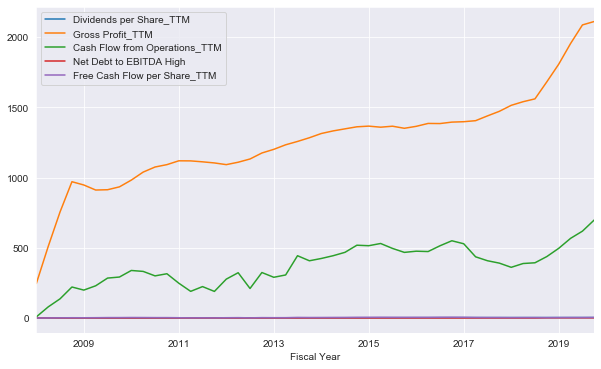

In [20]:
df1.plot(figsize=(10,6))
plt.show()

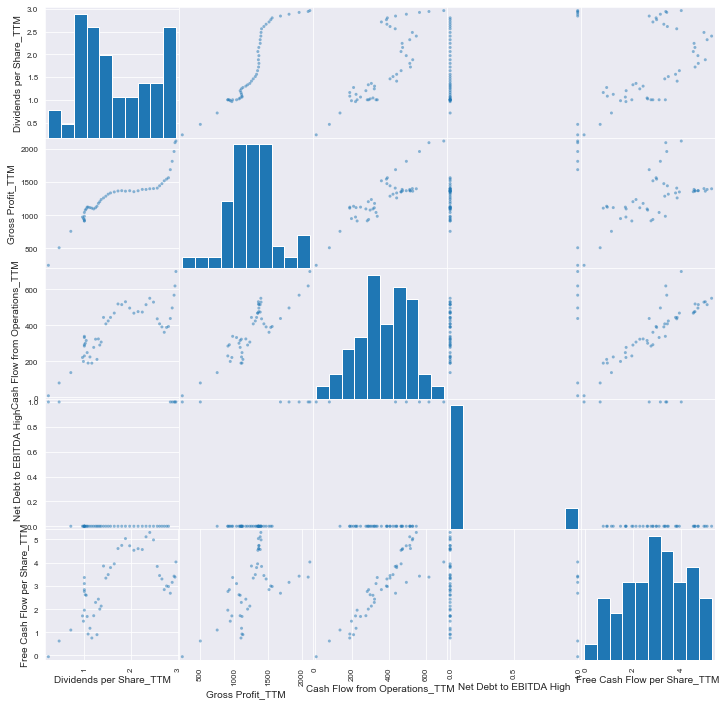

In [21]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(df1, figsize=(12,12))

## Algorithm Selection

In [22]:
#create a separate object for target variable
y = df1['Dividends per Share_TTM']

#create separate object for input features
X = df1.drop('Dividends per Share_TTM', axis=1)

In [23]:
#split Xand y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2,random_state=1234)

In [24]:
#sanity check
print(len(X_train), len(X_test), len(y_train), len(y_test))

38 10 38 10


## Model Training



In [25]:
#ignore convergence warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [26]:
#create dictionary for pipelines
pipelines = {
    'linear'  : make_pipeline(StandardScaler(), linear_model.LinearRegression()),
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state=123)),
    'rf'    : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb'    : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123)),
    
}

In [27]:
#linear
linear_hyperparameters = {
    
}

#Lasso hyperparameters
lasso_hyperparameters = {
    'lasso__alpha' : [.001, .005, .01, .05, .1, .5, 1, 5, 10]
    #'lasso__alpha' : [.5]
}

#Ridge hyperparameters
ridge_hyperparameters = {
    'ridge__alpha' : [.001, .005, .01, .05, .1, .5, 1, 5, 10]    
}

#ElasticNet hyper
enet_hyperparameters = {
    'elasticnet__alpha': [.001, .005, .01, .05, .1, .5, 1, 5, 10],
    'elasticnet__l1_ratio': [.1, .3, .5, .7, .9]
}

#random forest hyper parameters
rf_hyperparameters = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33]
}

# Boosted tree hyperparameters
gb_hyperparameters = { 
    'gradientboostingregressor__n_estimators': [100, 200],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}



In [28]:
# Create hyperparameters dictionary
hyperparameters = {
    'linear': linear_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters,
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters,
    
}

In [29]:
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso', 'linear']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

enet was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
lasso was found in hyperparameters, and it is a grid.
linear was found in hyperparameters, and it is a grid.


In [30]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

C:\Users\brett\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


linear has been fitted.


C:\Users\brett\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


lasso has been fitted.


C:\Users\brett\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge has been fitted.


C:\Users\brett\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


enet has been fitted.


C:\Users\brett\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


rf has been fitted.
gb has been fitted.


C:\Users\brett\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [31]:
for name, model in fitted_models.items():
    print(name, np.round(model.best_score_,3) )

linear 0.78
lasso 0.779
ridge 0.78
enet 0.779
rf 0.943
gb 0.924


In [32]:
#Using the most recent date to predict what the most current model predicted dividend per share

for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name)
    print('------')
    print('Upside Potential', np.round((model.predict(X.tail(1))/df1.iloc[-1,0])-1,3))
    print('Current Dividend', np.round(df1.iloc[-1,0],2))
    print('Predicted Dividend', np.round(model.predict(X.tail(1)),2))
    print('r^2:', np.round(r2_score(y_test, pred),3))
    print('MAE:', np.round(mean_absolute_error(y_test, pred),2))
    print('\n')

linear
------
Upside Potential [-0.062]
Current Dividend 2.96
Predicted Dividend [2.78]
r^2: 0.96
MAE: 0.13


lasso
------
Upside Potential [-0.048]
Current Dividend 2.96
Predicted Dividend [2.82]
r^2: 0.96
MAE: 0.13


ridge
------
Upside Potential [-0.057]
Current Dividend 2.96
Predicted Dividend [2.79]
r^2: 0.96
MAE: 0.13


enet
------
Upside Potential [-0.045]
Current Dividend 2.96
Predicted Dividend [2.83]
r^2: 0.959
MAE: 0.13


rf
------
Upside Potential [-0.017]
Current Dividend 2.96
Predicted Dividend [2.91]
r^2: 0.972
MAE: 0.07


gb
------
Upside Potential [-0.]
Current Dividend 2.96
Predicted Dividend [2.96]
r^2: 0.959
MAE: 0.09




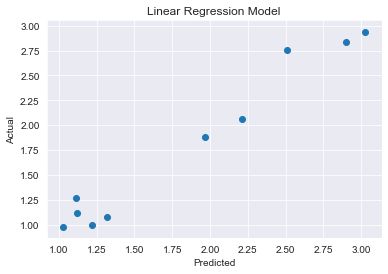

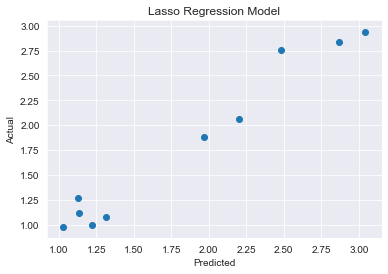

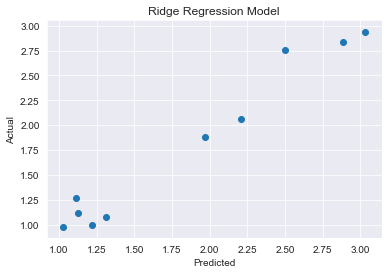

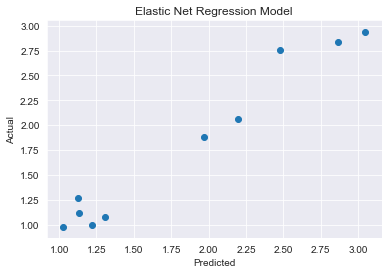

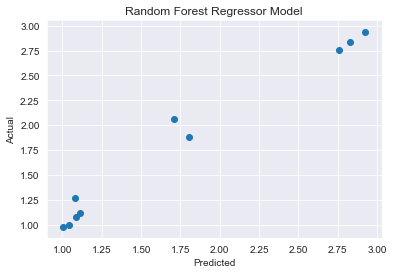

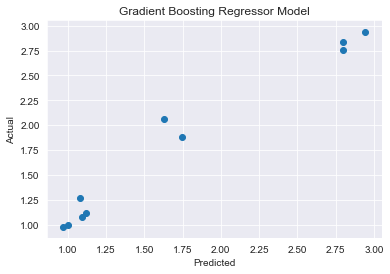

In [33]:
linear_pred = fitted_models['linear'].predict(X_test)
plt.scatter(linear_pred, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Linear Regression Model')
plt.show()


lasso_pred = fitted_models['lasso'].predict(X_test)
plt.scatter(lasso_pred, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Lasso Regression Model')
plt.show()

ridge_pred = fitted_models['ridge'].predict(X_test)
plt.scatter(ridge_pred, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ridge Regression Model')
plt.show()

enet_pred = fitted_models['enet'].predict(X_test)
plt.scatter(enet_pred, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Elastic Net Regression Model')
plt.show()

rf_pred = fitted_models['rf'].predict(X_test)
plt.scatter(rf_pred, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Regressor Model')
plt.show()

gb_pred = fitted_models['gb'].predict(X_test)
plt.scatter(gb_pred, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boosting Regressor Model')
plt.show()



linear


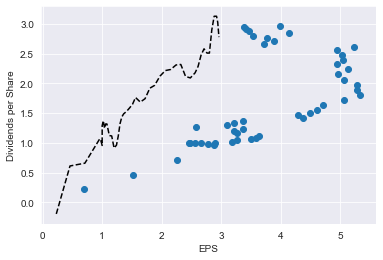

lasso


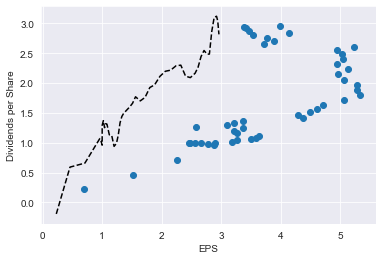

ridge


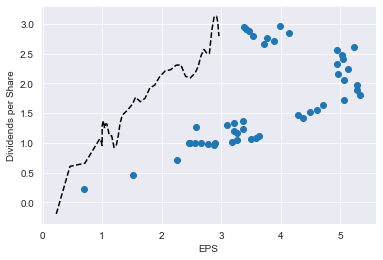

enet


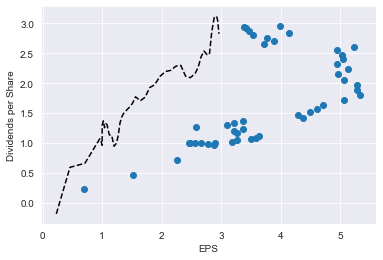

rf


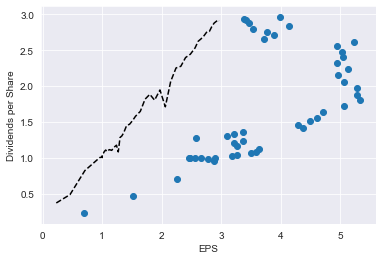

gb


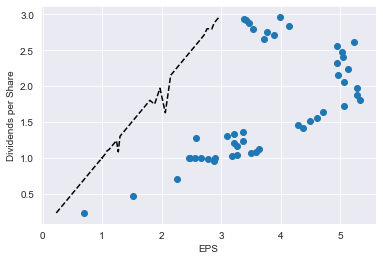

In [34]:
for name, model in fitted_models.items():
    
    print(name)
    plt.xlabel('EPS')
    plt.ylabel('Dividends per Share')
    plt.scatter(df['Earnings per Share (Diluted)_TTM'],df['Dividends per Share_TTM'])
    #plt.plot(df['Dividends per Share_TTM'], linear.predict(X), 'k--')
    plt.plot(df['Dividends per Share_TTM'],fitted_models[name].predict(X), 'k--')
    plt.show()

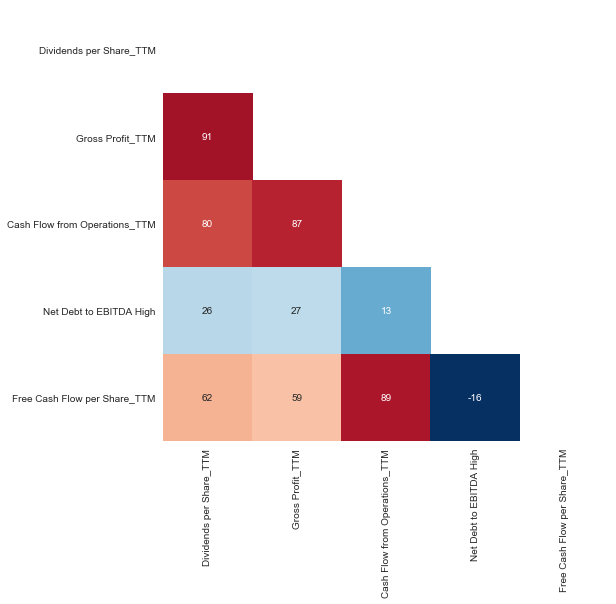

In [35]:
correlations = df1.corr()
# Make the figsize 9 x 8


# Plot heatmap of correlations
#this part cuts off the top half
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(8,8))
sns.set_style('white')
sns.heatmap(correlations*100, cmap='RdBu_r',annot=True, fmt='.0f', mask=mask, cbar=False) #cbar=False removes bar 
plt.show()

linear


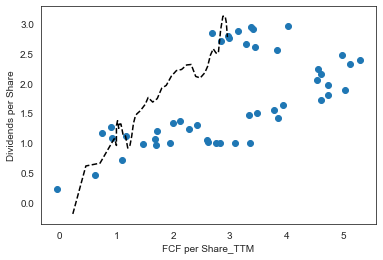

lasso


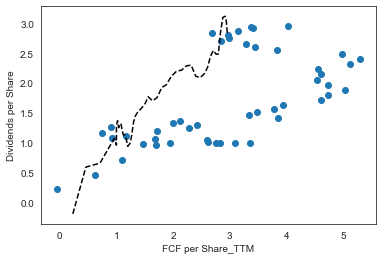

ridge


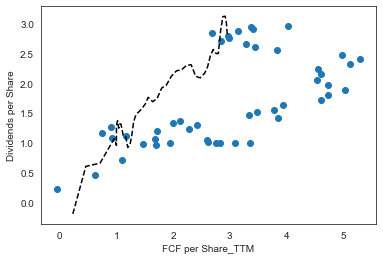

enet


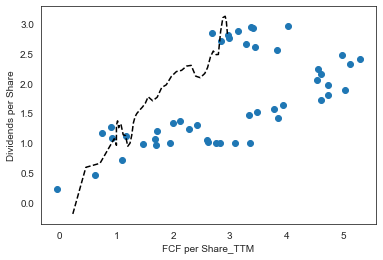

rf


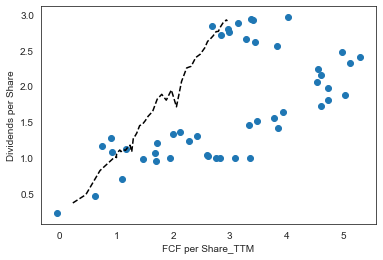

gb


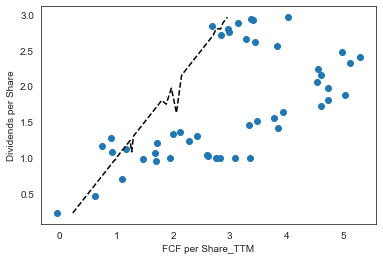

In [36]:
#Visualizing the fitted models and comparing the scatter to FCF and Dividends per share from the original df
for name, model in fitted_models.items():
    
    print(name)
    plt.xlabel('FCF per Share_TTM')
    plt.ylabel('Dividends per Share')
    plt.scatter(df['Free Cash Flow per Share_TTM'],df['Dividends per Share_TTM'])
    #plt.plot(df['Dividends per Share_TTM'], linear.predict(X), 'k--')
    plt.plot(df['Dividends per Share_TTM'],fitted_models[name].predict(X), 'k--')
    plt.show()

## Insights and Analysis

### In IFF's case, the winning model was RandomForest as the MAE was the lowest and the r-squared was 97.2%. The results suggest IFF's dividend should be lower by 1.7%. This is splitting hairs as it is so close to the current level of USD 2.96. What is potentially even more revealing is that all models predicted a lower dividend rate. While the data could potentially be overfit, the graphs of actual versus predicted appear relatively close. Additionally, a scatter plot of the dividends per share, Free Cash Flow per share and the predicted model suggest that the results are also reasonable. Intuitively, a company that produces more cash flow should be able to increase the dividend proportionately assuming it has a payout ratio that is not too high. Furthermore, high debt levels (>3.5) might also impact the ability and willingness to pay a dividend, particularly in a cyclical industry. 

## Cluster Analysis to Determine Unique Regimes 
### Using kmeans below to see if there are groups of years that are similar (regimes). I have run this cluster on several differnt companies and it often reveals interesting clusters. For example, when I examined Ford (F) it lumped the "recession years" in the same cluster, which is intuitive and important as the company was not likely to maintain its dividend policy if those conditions persisted.  
### As seen below, for International Flavors & Fragrance, it grouped two separate clusters when the company had elevated debt levels due to acquistions. One cluster occured when cash flow was strong (cluster 0) and the other when cash flow was weak (cluster 3). 

In [29]:
from sklearn.cluster import KMeans

In [30]:
X.head()

,Gross Profit_TTM,Cash Flow from Operations_TTM,Net Debt to EBITDA High,Free Cash Flow per Share_TTM
Fiscal Year,,,,
2008-03-01,245.482,7.641,1,-0.053
2008-06-01,509.263,78.850,1,0.623
2008-09-01,756.002,136.498,0,1.097
2008-12-01,970.937,220.613,0,1.705
2009-03-01,947.520,198.604,0,1.478


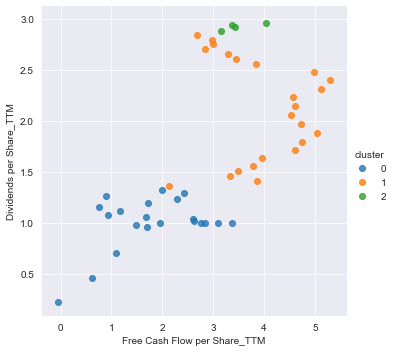

In [31]:
##repeating function to view "cluster" in df vs within function

model = KMeans(n_clusters=3, random_state=123)
#fit kmeans
kmeans = model
kmeans.fit(df1)

#predict clusters
clustered_data = df1.copy()
clustered_data['cluster'] = kmeans.predict(df1)

#scatterplot colored by cluster
sns.lmplot(x='Free Cash Flow per Share_TTM', y='Dividends per Share_TTM', hue = 'cluster', data = clustered_data, fit_reg=False)
plt.show()


In [32]:
clustered_data.sort_values('cluster')

,Dividends per Share_TTM,Gross Profit_TTM,Cash Flow from Operations_TTM,Net Debt to EBITDA High,Free Cash Flow per Share_TTM,cluster
Fiscal Year,,,,,,
2008-03-01,0.230,245.482,7.641,1,-0.053,0
2013-03-01,1.330,1201.495,289.879,0,1.999,0
2012-12-01,1.300,1175.534,323.796,0,2.427,0
2012-09-01,1.270,1132.864,210.042,0,0.896,0
2012-06-01,1.240,1109.715,322.411,0,2.287,0
2012-03-01,1.200,1092.595,276.770,0,1.714,0
2011-09-01,1.120,1112.604,223.537,0,1.173,0
2011-06-01,1.080,1119.277,189.641,0,0.924,0
2011-03-01,1.060,1119.855,247.800,0,1.681,0
